# Quy trình Tiền xử lý Dữ liệu

Notebook này thực hiện chuẩn hóa dữ liệu văn bản báo chí theo các bước:
1. **Làm sạch thô:** Quét ổ cứng và xóa các dòng chứa URL rác trong file.
2. **Tải dữ liệu:** Đọc file với cơ chế Safe Read (xử lý lỗi font) và chuẩn hóa Unicode.
3. **Khử trùng lặp:** Xóa vĩnh viễn các file có nội dung trùng nhau (dựa trên mã Hash).
4. **Lọc bài ngắn:** Xóa các bài viết có độ dài dưới 100 từ.
5. **Lọc nhiễu (ML):** Dùng Logistic Regression để phát hiện và di chuyển các bài viết sai chuyên mục.
6. **Đổi tên file:** Chuẩn hóa tên file theo định dạng `Topic_Source_SoThuTu.txt`.
7. **Kiểm tra ngẫu nhiên:** Xuất file Excel mẫu để kiểm tra thủ công.
8. **Thống kê:** Vẽ biểu đồ phân bố dữ liệu sau khi làm sạch.

In [1]:
import os
import re
import shutil
import hashlib
import random
import unicodedata
from pathlib import Path
from natsort import natsorted
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# --- Cấu hình ---
PROJECT_ROOT = Path.cwd().parent
DATA_ROOT = PROJECT_ROOT / "data" / "processed" / "data_filtered"
REPORT_DIR = PROJECT_ROOT / "reports"
MIN_WORD_COUNT = 100
ML_CONFIDENCE_THRESHOLD = 0.85
RANDOM_SEED = 42

# Cau hinh Spot Check
SPOT_CHECK_TOPICS = ["Ẩm thực", "Bất động sản", "Chứng khoán", "Công nghệ", "Đời sống"]
SPOT_CHECK_SIZE = 300

random.seed(RANDOM_SEED)
pd.set_option("display.max_colwidth", 200)

if not DATA_ROOT.exists():
    print(f"Canh bao: Khong tim thay thu muc {DATA_ROOT}")

## 1. Các hàm hỗ trợ (Helper Functions)

In [2]:
def clean_and_normalize_text(text):
    if not isinstance(text, str):
        return ""
    # Chuan hoa Unicode NFC
    text = unicodedata.normalize('NFC', text)
    # Xoa URL, Email, HTML tags
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    # Xoa khoang trang thua
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def file_hash(text):
    """Tinh ma MD5 cua van ban de phat hien trung lap."""
    return hashlib.md5(text.encode("utf-8")).hexdigest()

def safe_read_text(path):
    """Doc file voi nhieu bang ma khac nhau de tranh loi."""
    raw_data = path.read_bytes()
    text = None
    for encoding in ["utf-8-sig", "utf-8", "utf-16", "utf-16-le", "utf-16-be"]:
        try:
            text = raw_data.decode(encoding)
            break
        except UnicodeDecodeError:
            continue
    if text is None:
        text = raw_data.decode("utf-8", errors="ignore")
    return text.replace("\x00", "").replace("\u200b", "").strip()

def clean_url_lines(file_path):
    """Xoa cac dong chua URL truc tiep tren file."""
    url_pattern = re.compile(r'(http[s]?://|www\.)')
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        new_lines = [line for line in lines if not url_pattern.search(line) and not line.strip().startswith("Url:")]
        if len(new_lines) < len(lines):
            with open(file_path, 'w', encoding='utf-8') as f:
                f.writelines(new_lines)
            return len(lines) - len(new_lines)
    except Exception as e:
        pass
    return 0

def get_next_index(folder_path, prefix, cache):
    """Lay so thu tu tiep theo de dat ten file."""
    key = f"{folder_path}_{prefix}"
    if key not in cache:
        max_idx = 0
        if folder_path.exists():
            for f in folder_path.glob(f"{prefix}_*.txt"):
                try:
                    match = re.search(r'_(\d+)\.txt$', f.name)
                    if match: max_idx = max(max_idx, int(match.group(1)))
                except:
                    continue
        cache[key] = max_idx
    cache[key] += 1
    return cache[key]

## 2. Quét và Xóa URL trên ổ cứng
Bước này loại bỏ các dòng metadata chứa link trước khi load vào bộ nhớ.

In [ ]:
print(f"Dang quet URL trong: {DATA_ROOT} ...")
total_files = 0
total_removed = 0

for file_path in DATA_ROOT.rglob("*.txt"):
    total_files += 1
    total_removed += clean_url_lines(file_path)

print(f"Hoan tat. Da quet {total_files} file. So dong URL da xoa: {total_removed}")

## 3. Tải dữ liệu vào DataFrame

In [4]:
rows = []
print("Dang tai du lieu...")

for topic_dir in natsorted(DATA_ROOT.iterdir()):
    if not topic_dir.is_dir(): continue
    
    for txt_file in topic_dir.glob("*.txt"):
        try:
            raw_content = safe_read_text(txt_file)
            cleaned = clean_and_normalize_text(raw_content)
            if cleaned:
                rows.append({
                    "topic": topic_dir.name,
                    "filename": txt_file.name,
                    "file_path": str(txt_file),
                    "text": cleaned
                })
        except Exception:
            continue

df = pd.DataFrame(rows)
print(f"Da tai {len(df)} bai viet thuoc {df['topic'].nunique()} chu de.")

Dang tai du lieu...
Da tai 115188 bai viet thuoc 20 chu de.


## 4. Khử trùng lặp (Deduplication)
Sử dụng mã Hash MD5 để tìm và xóa các bài viết trùng lặp nội dung.

In [ ]:
print("Dang kiem tra trung lap...")
df["text_hash"] = df["text"].apply(file_hash)
df["is_duplicate"] = df.duplicated(subset=["text_hash"], keep="first")

duplicates = df[df["is_duplicate"]]
print(f"Phat hien {len(duplicates)} file trung lap.")

# Xoa file khoi o cung
count = 0
for path_str in duplicates["file_path"]:
    p = Path(path_str)
    if p.exists():
        p.unlink()
        count += 1

df_clean = df[~df["is_duplicate"]].copy().reset_index(drop=True)
print(f"Da xoa {count} file trung. Con lai: {len(df_clean)}")

## 5. Lọc bài viết ngắn (Length Filtering)

In [ ]:
print(f"Dang loc bai viet duoi {MIN_WORD_COUNT} tu...")
df_clean["word_count"] = df_clean["text"].apply(lambda x: len(x.split()))

short_mask = df_clean["word_count"] < MIN_WORD_COUNT
short_files = df_clean[short_mask]
print(f"Tim thay {len(short_files)} bai qua ngan.")

# Xoa file ngan
count = 0
for path_str in short_files["file_path"]:
    p = Path(path_str)
    if p.exists():
        p.unlink()
        count += 1

df_final = df_clean[~short_mask].copy().reset_index(drop=True)
print(f"Da xoa {count} file ngan. Du lieu sach san sang cho ML: {len(df_final)}")

## 6. Lọc nhiễu nhãn bằng Machine Learning
Dùng Logistic Regression để tìm các bài viết bị đặt sai thư mục và di chuyển chúng về đúng chỗ.

In [ ]:
print("Dang huan luyen mo hinh de loc nhieu...")
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1, 2), min_df=5)
X = tfidf.fit_transform(df_final['text'])
y = df_final['topic']

clf = LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag')
y_pred = cross_val_predict(clf, X, y, cv=3, n_jobs=-1)
y_proba = cross_val_predict(clf, X, y, cv=3, method='predict_proba', n_jobs=-1)

classes = clf.fit(X, y).classes_
max_probs = [probs[np.where(classes == pred)[0][0]] for probs, pred in zip(y_proba, y_pred)]

df_final['pred_topic'] = y_pred
df_final['conf'] = max_probs

# Loc cac bai sai nhan voi do tin cay cao
mislabeled = df_final[(df_final['topic'] != df_final['pred_topic']) & (df_final['conf'] >= ML_CONFIDENCE_THRESHOLD)]
print(f"Phat hien {len(mislabeled)} bai sai chu de.")

# Di chuyen file ve dung thu muc
moved = 0
for _, row in mislabeled.iterrows():
    src = Path(row['file_path'])
    dst_folder = DATA_ROOT / row['pred_topic']
    dst_folder.mkdir(exist_ok=True)
    dst = dst_folder / src.name
    if src.exists():
        shutil.move(str(src), str(dst))
        moved += 1

print(f"Da di chuyen {moved} file ve dung chu de.")

## 7. Đổi tên và Chuẩn hóa file
Đổi tên toàn bộ file theo định dạng: `Topic_Source_SoThuTu.txt`.

In [8]:
TOPIC_MAP = {
    "Bất động sản": "BDS", "Chứng khoán": "CK", "Công nghệ": "CN", "Du lịch": "DL",
    "Gia đình": "GD", "Giao thông": "GT", "Giáo dục": "GDU", "Giải trí": "GTRI",
    "Khoa học": "KH", "Khởi nghiệp": "KN", "Kinh doanh": "KD", "Nông nghiệp": "NN",
    "Pháp luật": "PL", "Sức khỏe": "SK", "Thế giới": "TG", "Thể thao": "TT",
    "Thời sự – Chính trị": "TSCT", "Văn hóa": "VH", "Đời sống": "DS", "Ẩm thực": "AT", "Xã hội": "XH"
}

def get_source(filename):
    parts = filename.replace(".txt", "").split("_")
    return parts[1] if len(parts) >= 2 else "UNKNOWN"

print("Dang doi ten file...")
renamed_total = 0

for topic_dir in natsorted(DATA_ROOT.iterdir()):
    if not topic_dir.is_dir(): continue
    
    topic_code = TOPIC_MAP.get(topic_dir.name, "OTHER")
    files = natsorted(list(topic_dir.glob("*.txt")))

    processing_queue = []

    for i, fpath in enumerate(files, 1):
        try:
            source = get_source(fpath.name)

            temp_name = f"__TEMP_{i}_{fpath.name}"
            temp_path = topic_dir / temp_name

            fpath.rename(temp_path)
            processing_queue.append((temp_path, source, i))
        except Exception as e:
            print(f"⚠️ Lỗi tạo file tạm cho {fpath.name}: {e}")

    for temp_path, source, i in processing_queue:
        try:
            new_name = f"{topic_code}_{source}_{i}.txt"
            new_path = topic_dir / new_name

            temp_path.rename(new_path)
            renamed_total += 1
        except Exception as e:
            print(f"Lỗi đổi tên chính thức {new_name}: {e}")

print(f"Hoàn tất. Đã đổi tên chuẩn hóa {renamed_total} file.")

Dang doi ten file...
Hoàn tất. Đã đổi tên chuẩn hóa 115188 file.


## 8. Kiểm tra ngẫu nhiên (Spot Checking)
Xuất một file Excel chứa mẫu ngẫu nhiên từ các chủ đề quan trọng để kiểm tra thủ công.

In [ ]:
print("Dang tao file mau kiem tra (Spot Check)...")
spot_samples = []

available_topics = df_final["topic"].unique()

for topic in SPOT_CHECK_TOPICS:
    if topic in available_topics:
        topic_data = df_final[df_final["topic"] == topic]
        n = min(SPOT_CHECK_SIZE, len(topic_data))
        if n > 0:
            sample = topic_data.sample(n=n, random_state=RANDOM_SEED)
            spot_samples.append(sample)

if spot_samples:
    df_spot = pd.concat(spot_samples, ignore_index=True)
    REPORT_DIR.mkdir(parents=True, exist_ok=True)
    output_file = REPORT_DIR / "spot_check_samples.xlsx"

    try:
        df_spot.to_excel(output_file, index=False)
        print(f"Da xuat {len(df_spot)} mau kiem tra ra: {output_file}")
    except Exception as e:
        print(f"Khong the xuat Excel: {e}")

## 9. Thống kê phân bố dữ liệu

C:\Users\yello\AppData\Local\Temp\ipykernel_37728\1407028781.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_stats, x="Count", y="Topic", palette="viridis")


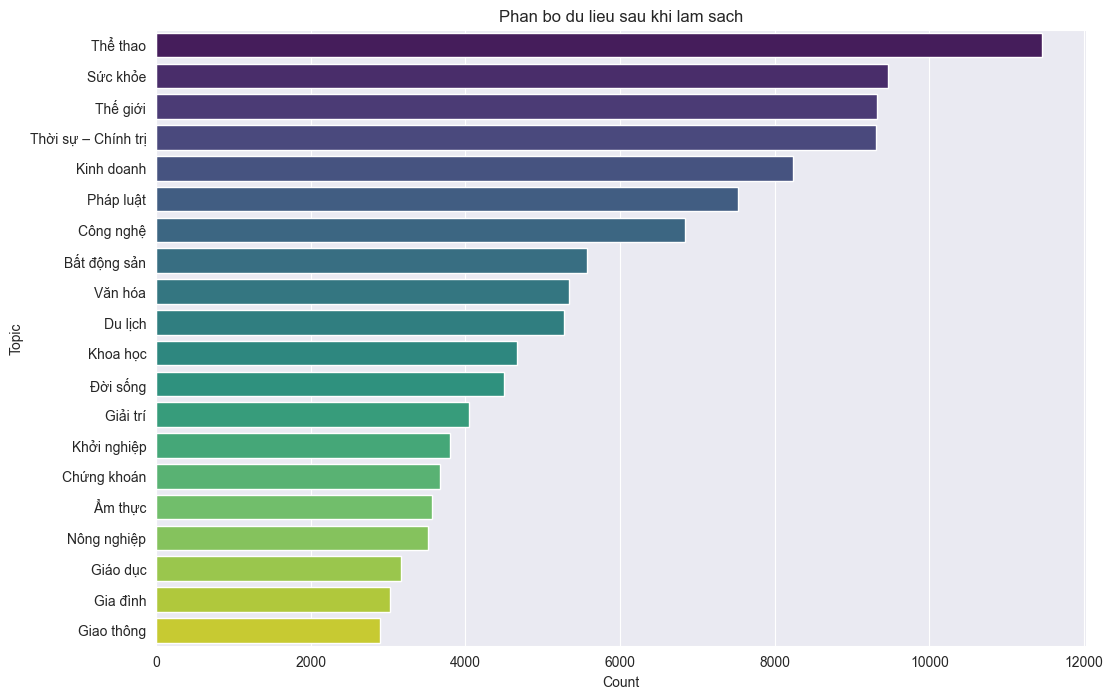

                  Topic  Count
15             Thể thao  11452
13             Sức khỏe   9467
14             Thế giới   9325
16  Thời sự – Chính trị   9304
10           Kinh doanh   8232
12            Pháp luật   7530
2             Công nghệ   6845
0          Bất động sản   5571
17              Văn hóa   5337
3               Du lịch   5278
8              Khoa học   4661
18             Đời sống   4497
7              Giải trí   4046
9           Khởi nghiệp   3798
1           Chứng khoán   3668
19              Ẩm thực   3573
11          Nông nghiệp   3520
6              Giáo dục   3166
4              Gia đình   3019
5            Giao thông   2899


In [10]:
stats = []
for topic_dir in DATA_ROOT.iterdir():
    if topic_dir.is_dir():
        count = len(list(topic_dir.glob("*.txt")))
        if count > 0:
            stats.append({"Topic": topic_dir.name, "Count": count})

df_stats = pd.DataFrame(stats).sort_values("Count", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_stats, x="Count", y="Topic", palette="viridis")
plt.title("Phan bo du lieu sau khi lam sach")
plt.show()

print(df_stats)